In [1]:
# Importing libraries to use:
library('data.table')
library('forecast')
library('ggplot2')
library('rugarch')
library('timeSeries')
library('fImport')
library('fPortfolio')
library('GeneCycle')
library('quantmod')

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Loading required package: timeDate

Loading required package: fBasics

Loading required package: fAssets

Loading required package: MASS

Loading required package: longitudinal

Loading required package: corpcor

Loading required package: fdrtool


Attaching package: 'GeneCycle'


The following object is masked from 'package:forecast':

    is.constant


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following object is masked from 'package:timeSeries':

    time<-


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:data.table':

    first, last


Loading required package: TTR


Attaching package: 'TTR

In [2]:
# Setting plotting options
options(repr.plot.height=8, repr.plot.width=12)

In [3]:
# Reading data from csv and checking
means <- fread('housing_means.csv')
head(means)

V1,mean price
<date>,<dbl>
1996-04-01,118299.1
1996-05-01,118419.0
1996-06-01,118537.4
1996-07-01,118653.1
1996-08-01,118780.3
1996-09-01,118927.5


In [6]:
# Renaming the columns
colnames(means) <- c('date', 'meanPrice')

head(means)

date,meanPrice
<date>,<dbl>
1996-04-01,118299.1
1996-05-01,118419.0
1996-06-01,118537.4
1996-07-01,118653.1
1996-08-01,118780.3
1996-09-01,118927.5


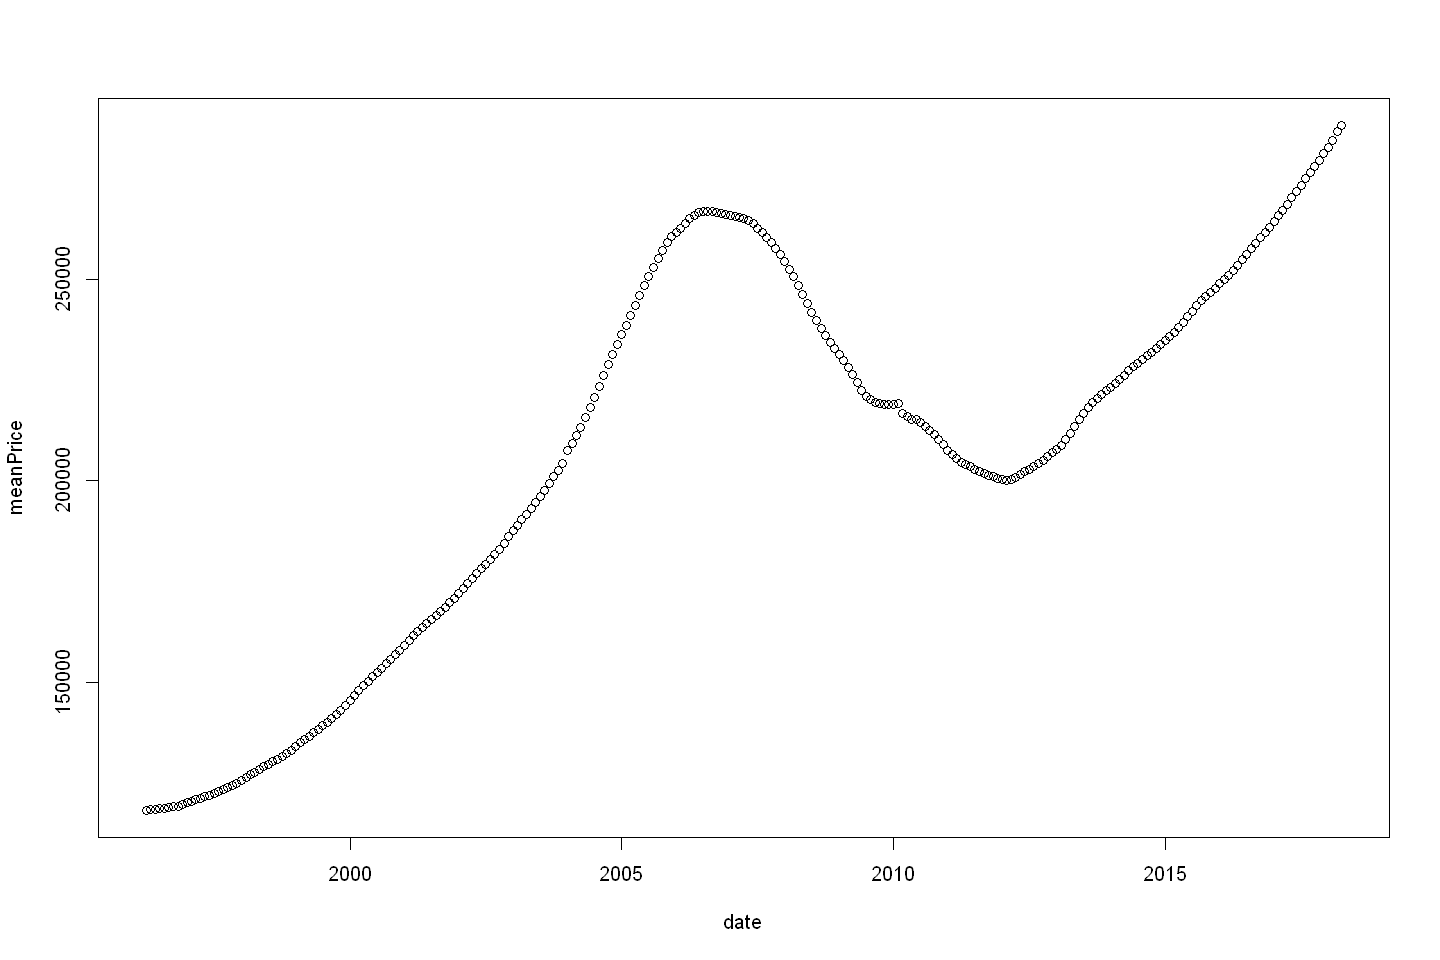

In [7]:
# Plotting the means from all zipcodes in the original dataset
plot(means)

Above we can see the behavior of the overall housing market across all zipcodes in the original dataset. Notice the large crash occurring between 2007 and 2013, caused by the Great Recession. This event, while specific in its causes, may be useful to help generate warning signs of future tumult in the markets which could be taken advantage of for asset protection.

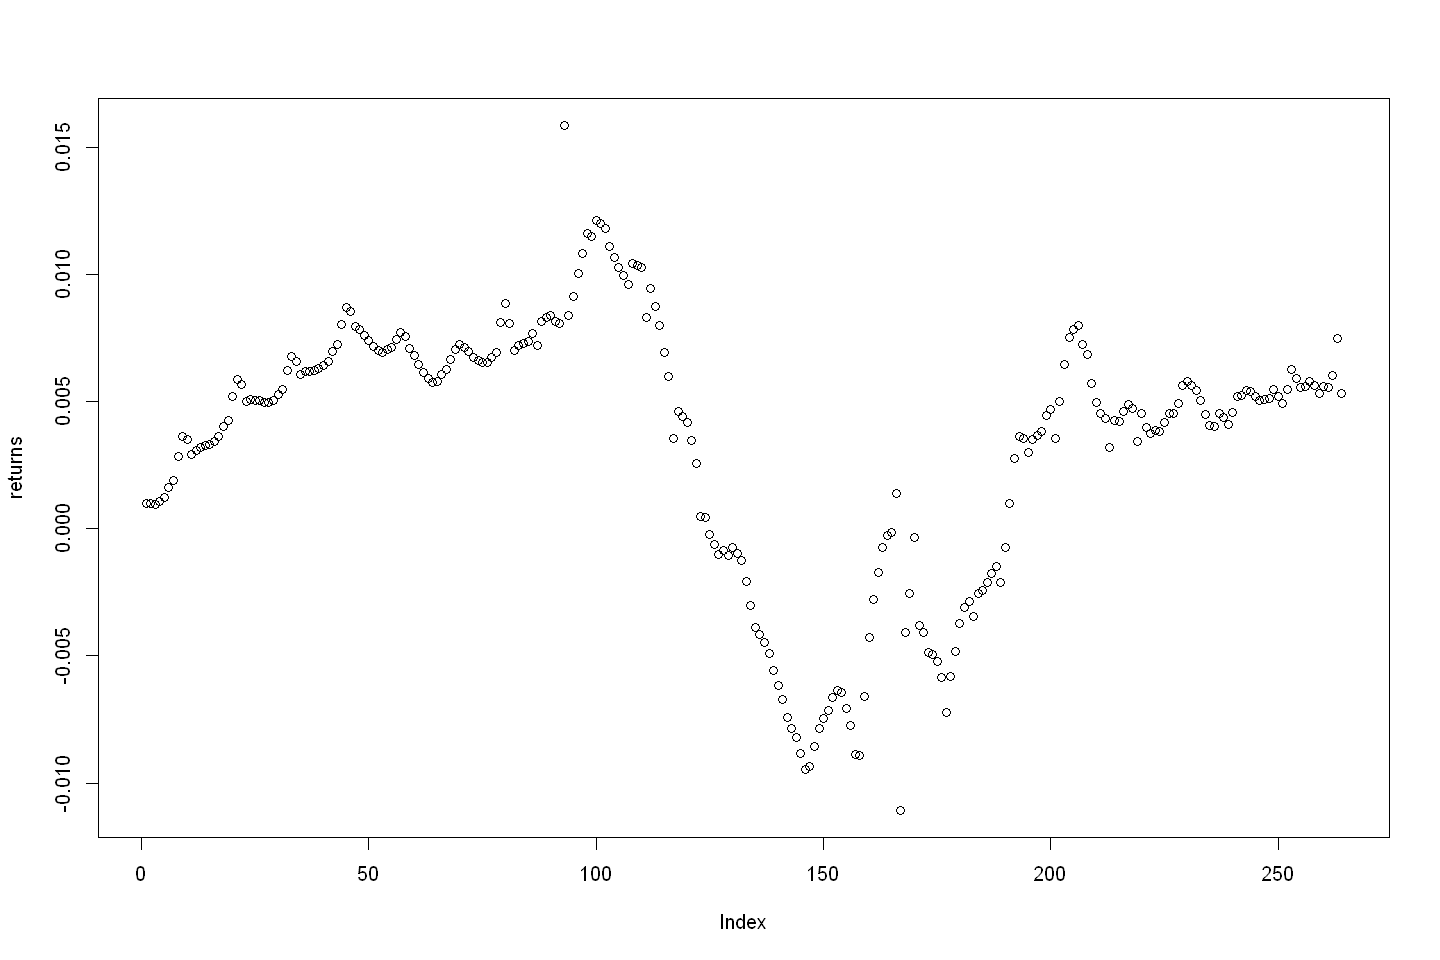

In [8]:
# Looking at the returns of the series
returns <- na.omit(diff(log(means$meanPrice)))
plot(returns)

We can see that the returns do not seem to be stationary

In [9]:
# Appending returns to the data.table
means$returns <- returns(means$meanPrice)
head(means)

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-04-01,118299.1,NA
1996-05-01,118419.0,0.0010131971
1996-06-01,118537.4,0.0009991636
1996-07-01,118653.1,0.0009751320
1996-08-01,118780.3,0.0010713327
1996-09-01,118927.5,0.0012391198


In [20]:
# A quick example of dropping rows/columns in r, where a negative sign is placed in front of the
# index of the desired row or column to drop. Below we drop the first row and third column
head(means[-1,-3])

date,meanPrice
<date>,<dbl>
1996-05-01,118419.0
1996-06-01,118537.4
1996-07-01,118653.1
1996-08-01,118780.3
1996-09-01,118927.5
1996-10-01,119120.5


In [21]:
# Before converting to timeseries, must fix date type
means$date <- as.Date(means$date)

In [22]:
# Making a timeseries of class xts. Notice that the first row with the NaN is dropped
ts1 <- xts(means[-1]$returns, means[-1]$date)
head(ts1)

                   [,1]
1996-05-01 0.0010131971
1996-06-01 0.0009991636
1996-07-01 0.0009751320
1996-08-01 0.0010713327
1996-09-01 0.0012391198
1996-10-01 0.0016214530

In [23]:
# Checking class of time series
class(ts1)

[1] "xts" "zoo"

In [24]:
# Making a second timeseries of class timeSeries, which is useful for other functions
ts2 <- timeSeries(ts1)
colnames(ts2) <- c('returns')
head(ts2)

GMT
                returns
1996-05-01 0.0010131971
1996-06-01 0.0009991636
1996-07-01 0.0009751320
1996-08-01 0.0010713327
1996-09-01 0.0012391198
1996-10-01 0.0016214530

In [25]:
class(ts2)

[1] "timeSeries"
attr(,"package")
[1] "timeSeries"

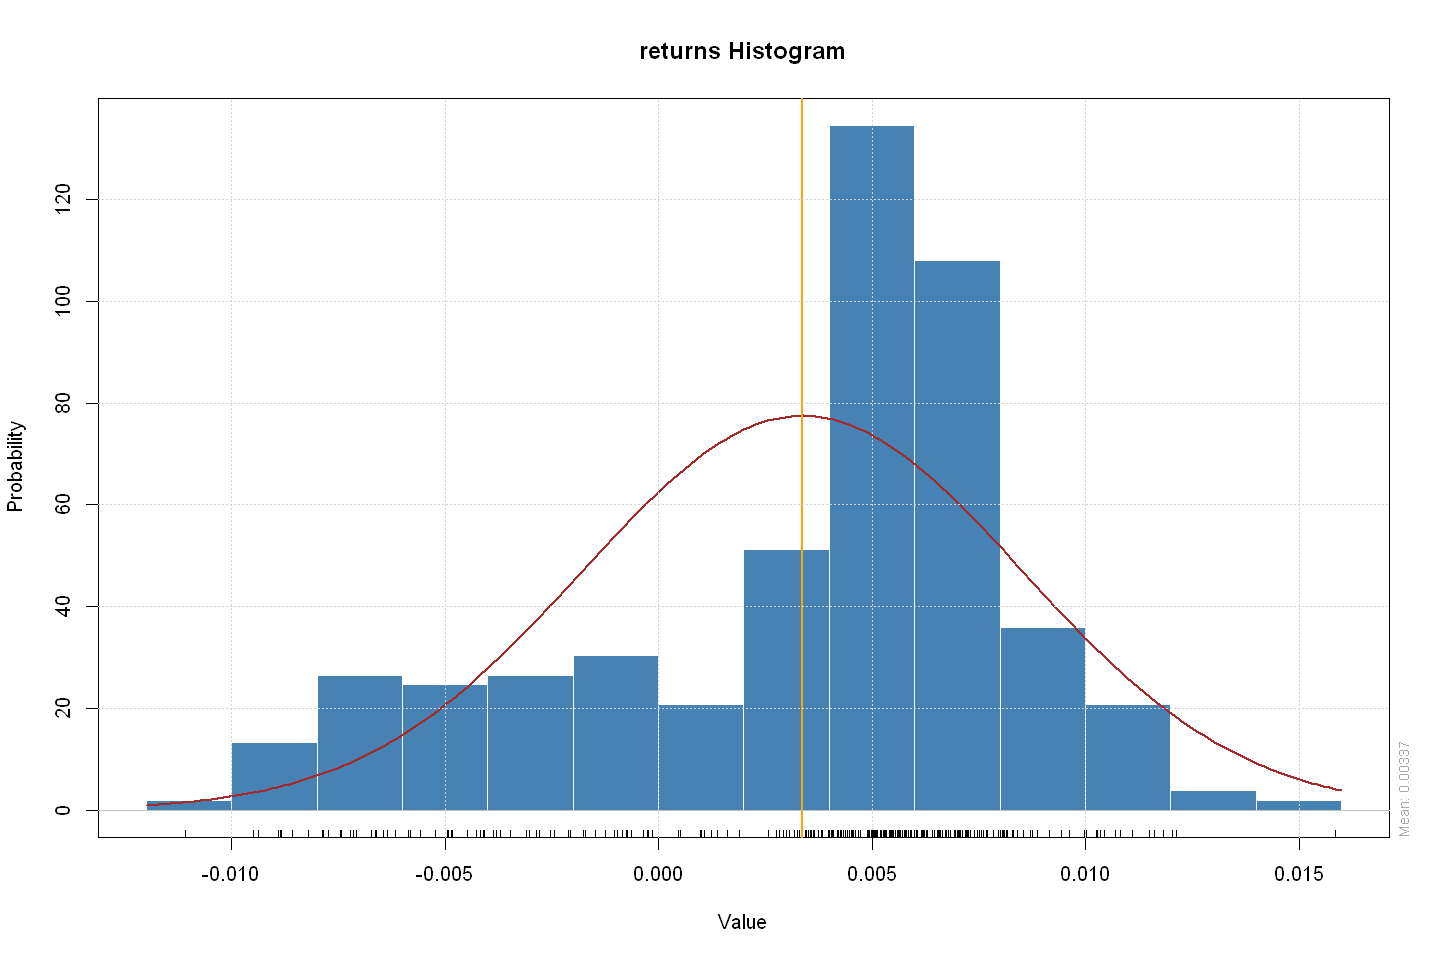

In [26]:
# For instance, this function would only accept a 'timeSeries' class object
histPlot(ts2)

In [27]:
# We can see from the histogram above that the returns have a non-zero mean and substantial 
# negative skew
print(c('Mean', mean(ts1)))
print(c('Skewness', skewness(ts1)))

[1] "Mean"                "0.00337076821168298"
[1] "Skewness"           "-0.840773789839174"


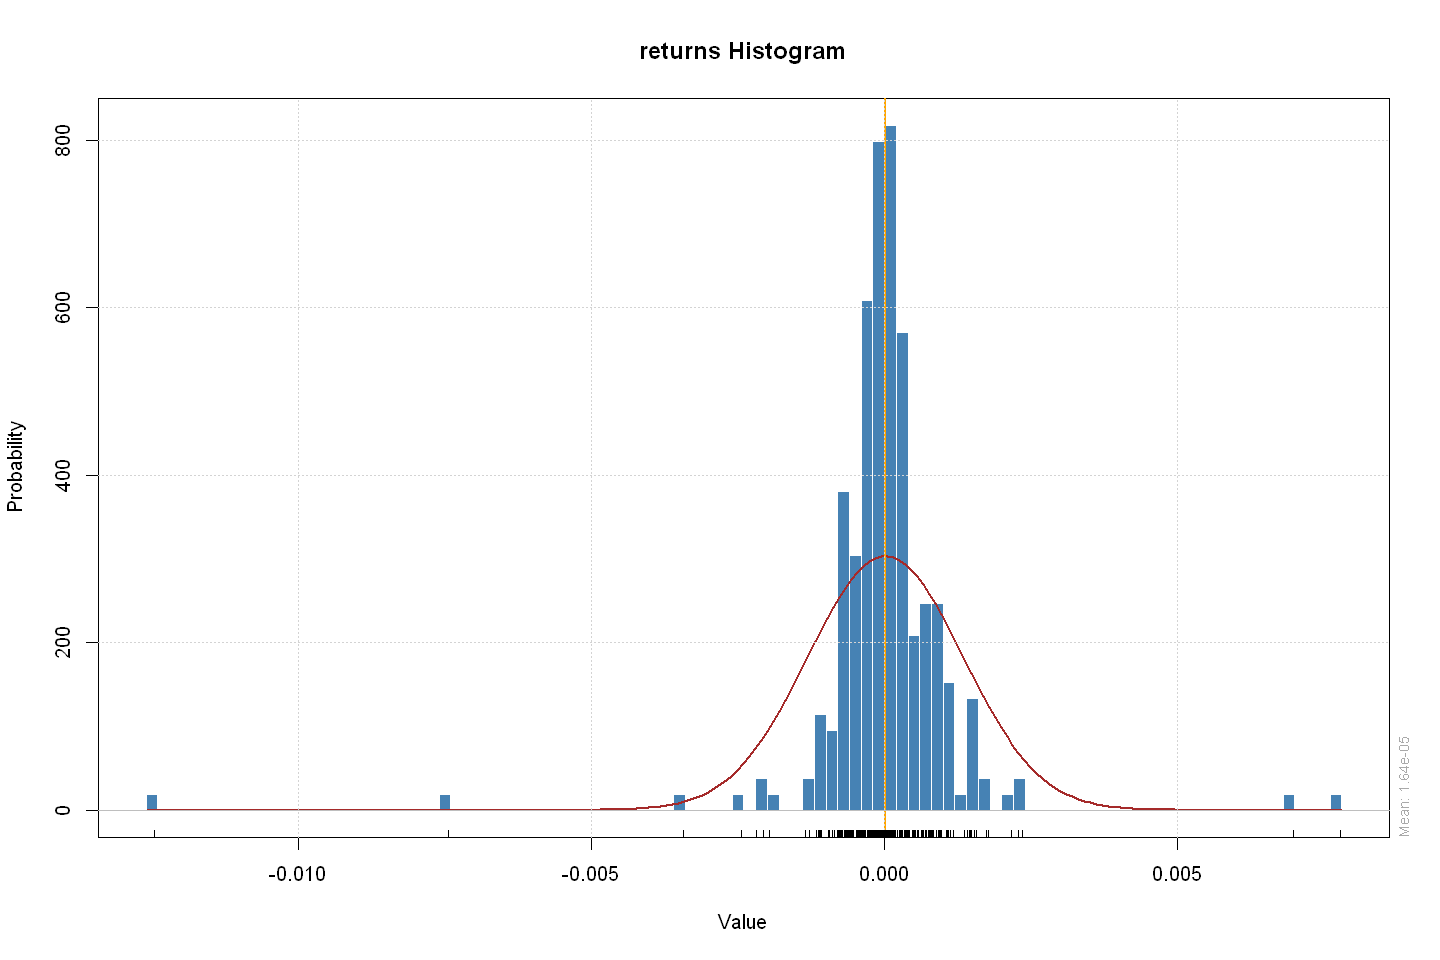

In [28]:
# Lets see how another differencing would look
histPlot(na.omit(diff(ts2)))

In [29]:
# We can see now that the mean is much closer to zero, with less skew
# It can also be seen that the distribution is extremely tall with thin tails, meaning
# a normal distribution may not be the best model distribution
print('Mean')
mean(na.omit(diff(ts1)))
print('Skew')
skewness(na.omit(diff(ts1)))

[1] "Mean"


[1] 1.637918e-05

[1] "Skew"


[1] -2.620879
attr(,"method")
[1] "moment"

In [30]:
# We can see that although the mean was fixed to zero with the differencing, the excess skew
# actually increased. This means it might be necessary to use a skewed distribution in modeling

In [31]:
# I will now make another time series of standardized means, in case it comes in handy

In [32]:
sd(means$meanPrice)

[1] 47809.38

In [33]:
standard_means <- (means$meanPrice-mean(means$meanPrice))/sd(means$meanPrice)

In [34]:
ts_std_means <- xts(standard_means, means$date)
head(ts_std_means)

                [,1]
1996-04-01 -1.848223
1996-05-01 -1.845714
1996-06-01 -1.843238
1996-07-01 -1.840819
1996-08-01 -1.838159
1996-09-01 -1.835079

[1] "Mean"                 "2.09900722327403e-16"
[1] "Skewness"           "-0.410033004291111"


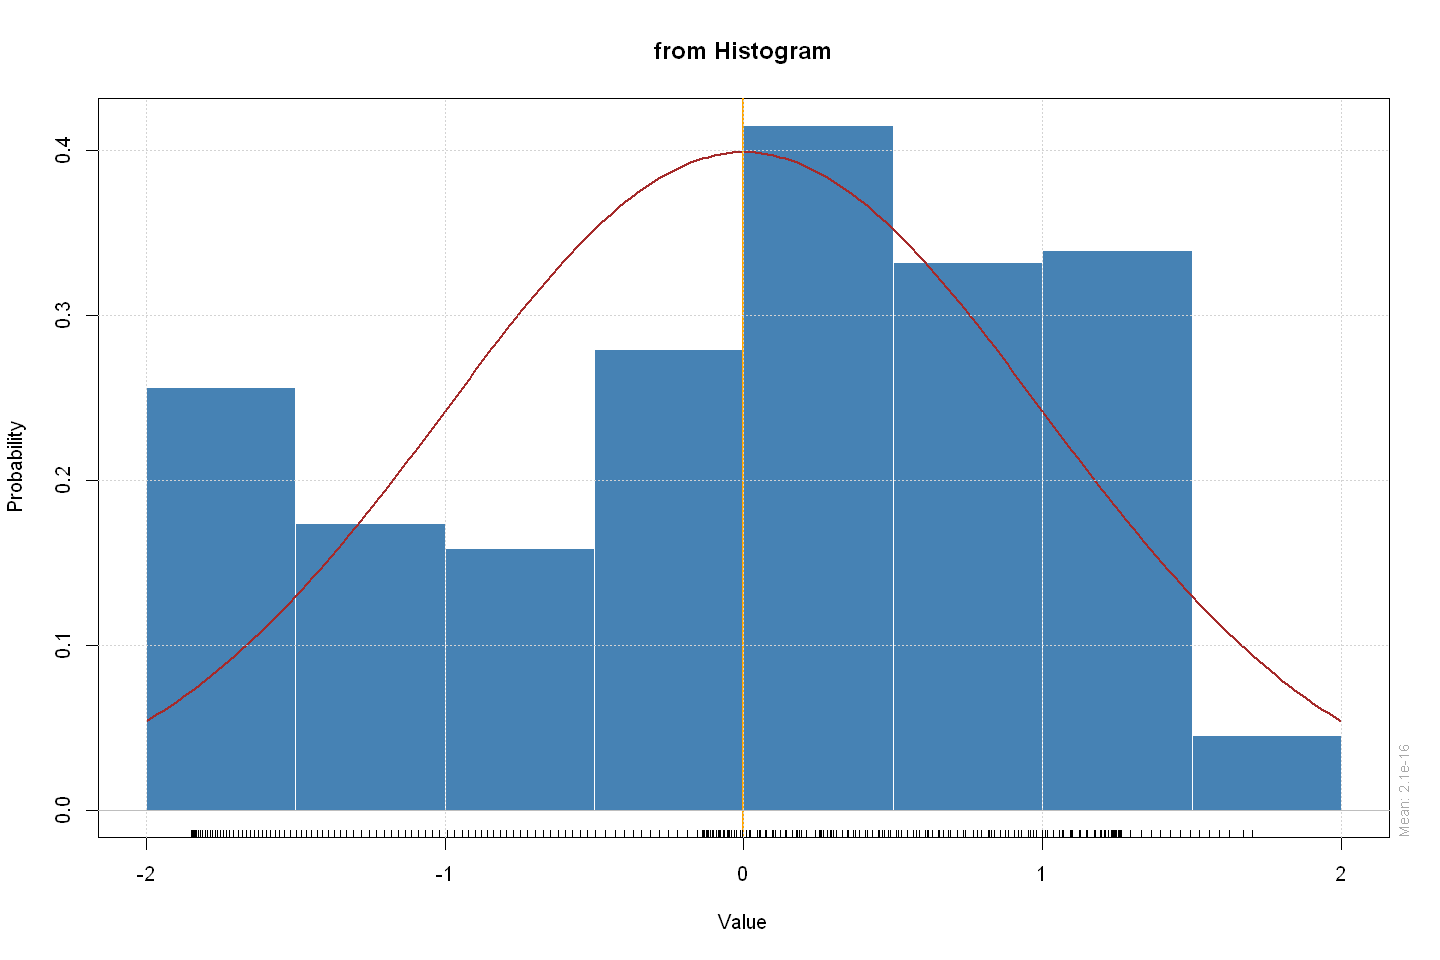

In [35]:
print(c('Mean', mean(ts_std_means)))
print(c('Skewness', skewness(ts_std_means)))
histPlot(timeSeries(ts_std_means))

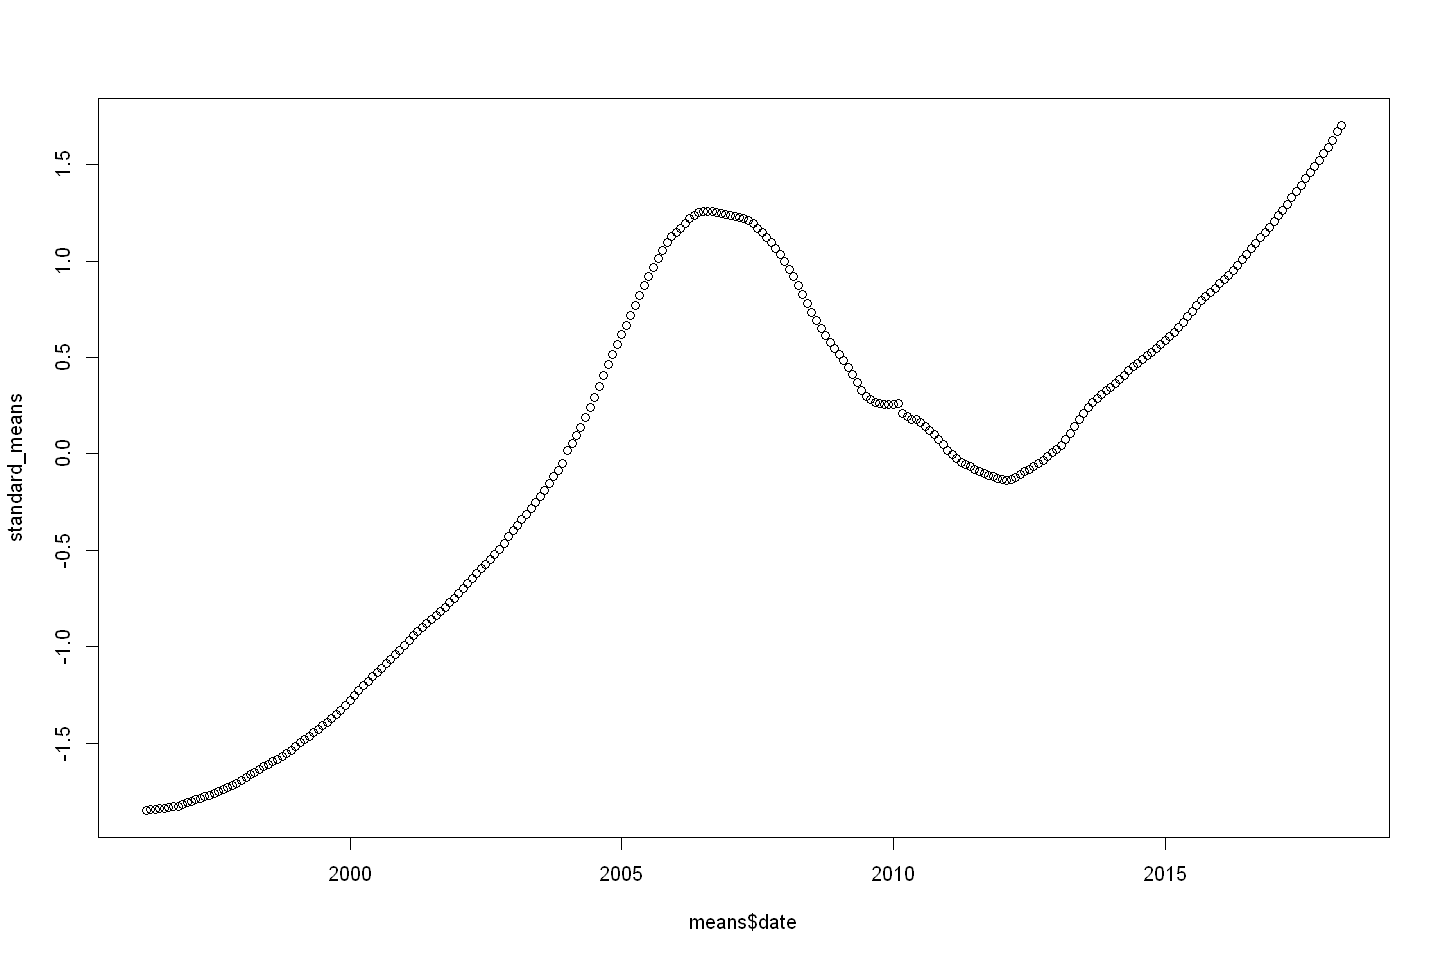

In [36]:
plot(x=means$date, y=standard_means)

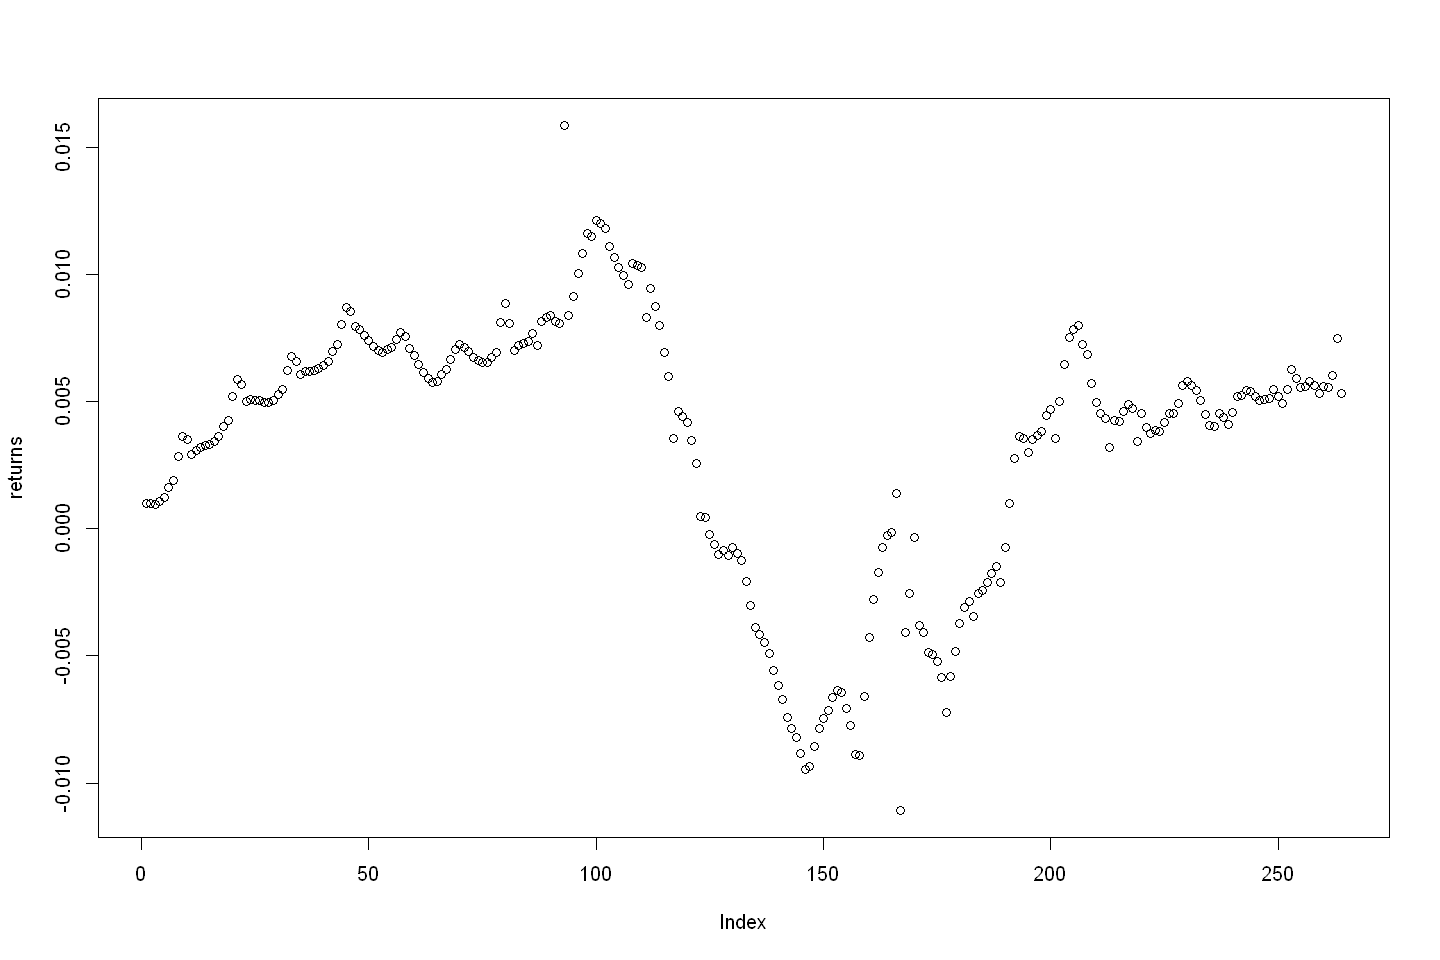

In [37]:
# A look at the returns
plot(returns)

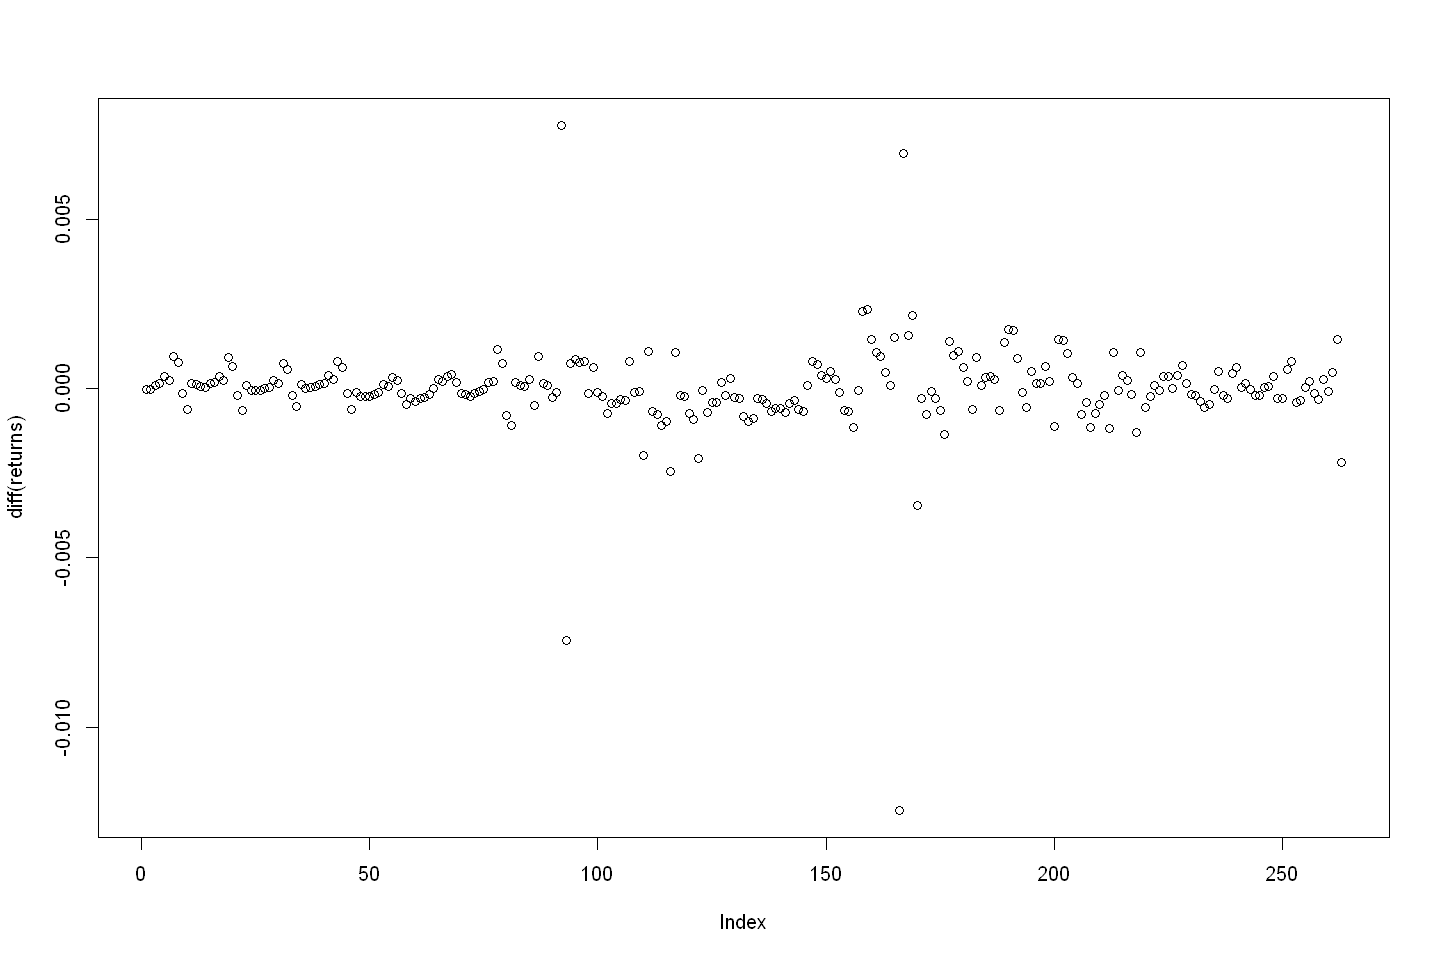

In [38]:
# Looking at differenced returns, to remove trend:
plot(diff(returns))

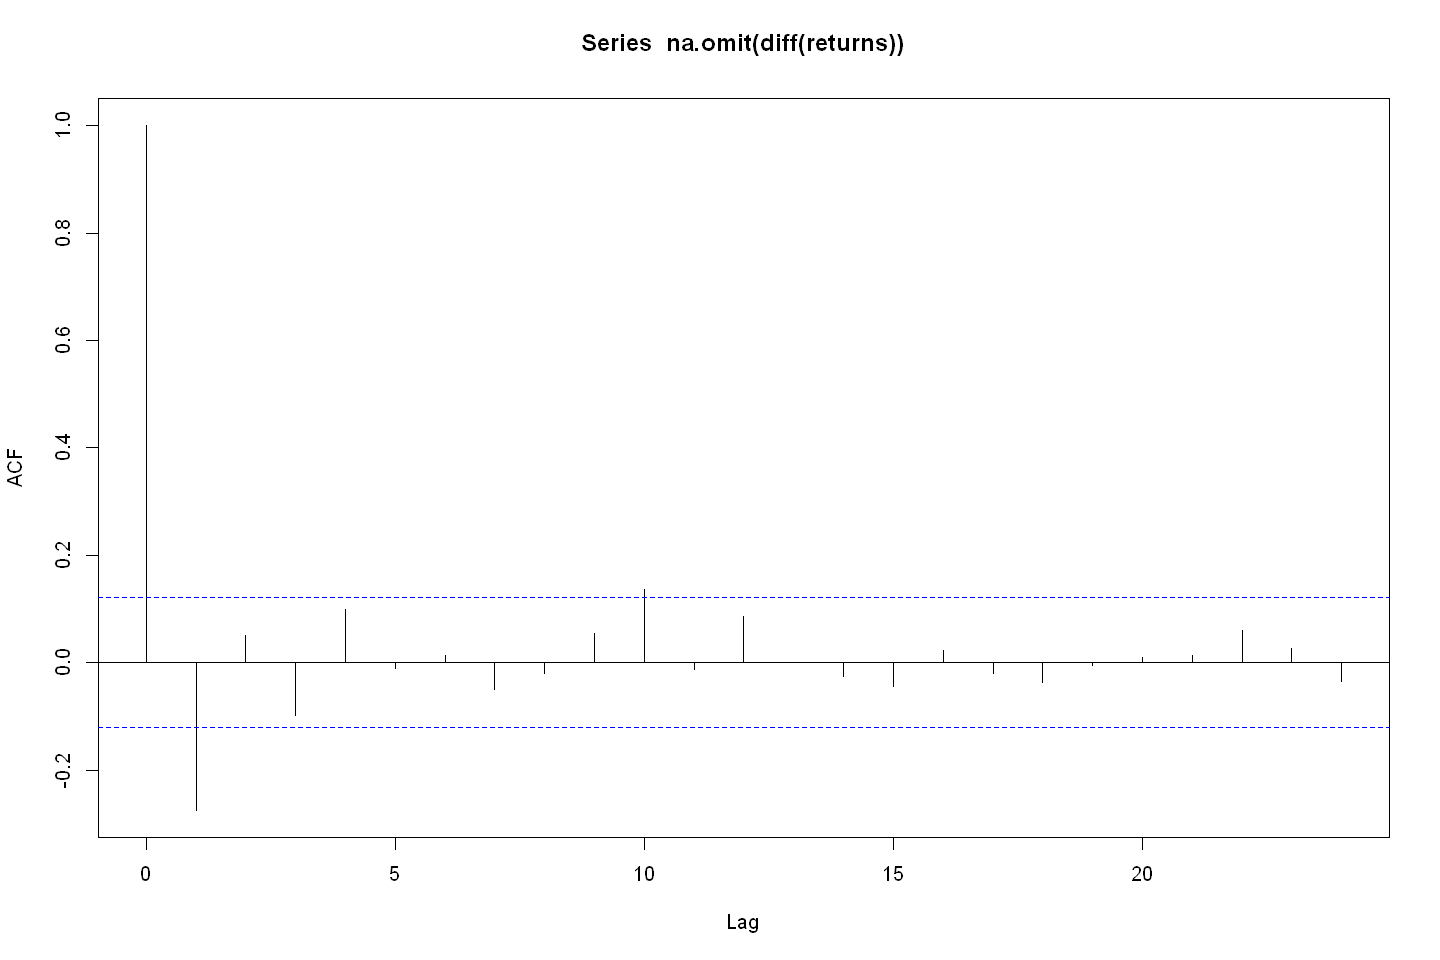

In [39]:
# A look at the ACF for differenced returns
acf(na.omit(diff(returns)))

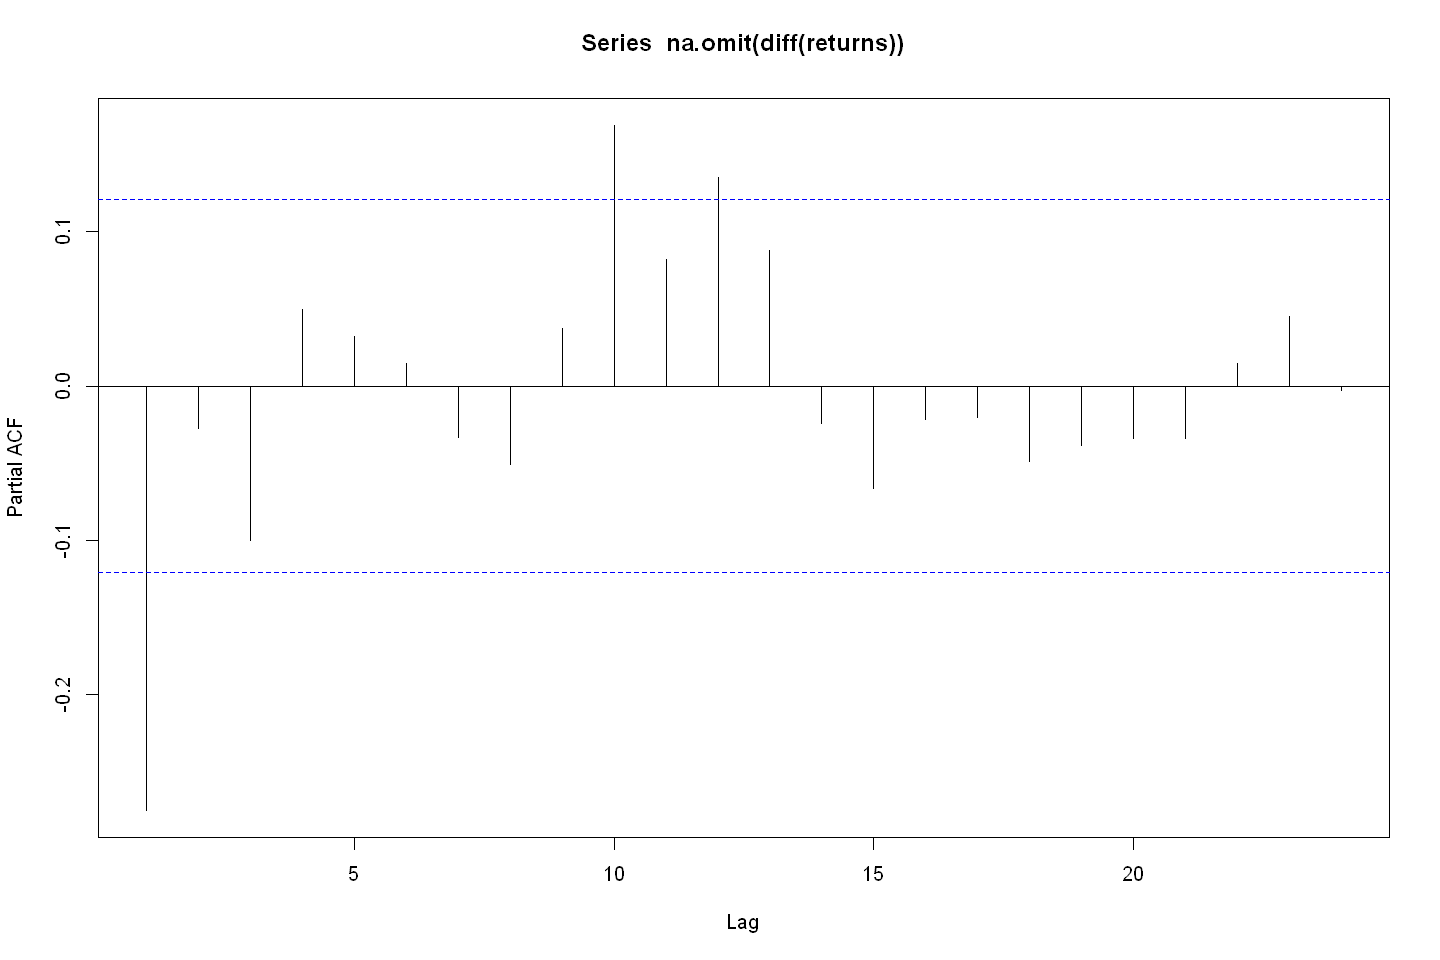

In [40]:
# A look at the PACF for differenced returns
pacf(na.omit(diff(returns)))

In [41]:
# A look at optimal arima parameters for the raw means data
auto.arima(means$meanPrice)

Series: means$meanPrice 
ARIMA(0,2,1) 

Coefficients:
          ma1
      -0.2677
s.e.   0.0576

sigma^2 estimated as 76084:  log likelihood=-1850.54
AIC=3705.08   AICc=3705.12   BIC=3712.22

In [42]:
auto.arima(ts1)

Series: ts1 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.2834
s.e.   0.0583

sigma^2 estimated as 1.598e-06:  log likelihood=1382.4
AIC=-2760.79   AICc=-2760.74   BIC=-2753.65

In [43]:
args(ugarchspec)

function (variance.model = list(model = "sGARCH", garchOrder = c(1, 
    1), submodel = NULL, external.regressors = NULL, variance.targeting = FALSE), 
    mean.model = list(armaOrder = c(1, 1), include.mean = TRUE, 
        archm = FALSE, archpow = 1, arfima = FALSE, external.regressors = NULL, 
        archex = FALSE), distribution.model = "norm", start.pars = list(), 
    fixed.pars = list(), ...) 
NULL

In [44]:
# Setting up specification object for the time series of returns, using the optimal ARIMA
# parameters determined above
# Note that the d=1 must be established by setting arfima=True and fixed.pars arfima=1
# Also, I will use the 'sstd' distribution model, which represents a skewed student's t dist
spec <- ugarchspec(variance.model = list(model='sGARCH',
                                          garchOrder=c(1,1)
                                         ),
                    mean.model = list(armaOrder=c(0,1,1),
                                      include.mean=F,
                                      archm=TRUE,
                                      arfima=TRUE
                                     ),
                    distribution.model = 'sstd',
                    fixed.pars = list(arfima=1,
                                      omega=0
                                     )
                   )

In [45]:
args(ugarchfit)

function (spec, data, out.sample = 0, solver = "solnp", solver.control = list(), 
    fit.control = list(stationarity = 1, fixed.se = 0, scale = 0, 
        rec.init = "all", trunclag = 1000), numderiv.control = list(grad.eps = 1e-04, 
        grad.d = 1e-04, grad.zero.tol = sqrt(.Machine$double.eps/7e-07), 
        hess.eps = 1e-04, hess.d = 0.1, hess.zero.tol = sqrt(.Machine$double.eps/7e-07), 
        r = 4, v = 2), ...) 
NULL

In [46]:
fit <- ugarchfit(spec, ts1)

In [47]:
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,d,1)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
ma1      0.30788    0.048805   6.3082 0.000000
arfima   1.00000          NA       NA       NA
archm    1.12273    0.299825   3.7446 0.000181
omega    0.00000          NA       NA       NA
alpha1   0.24237    0.053763   4.5081 0.000007
beta1    0.75663    0.050592  14.9555 0.000000
skew     0.99636    0.061714  16.1446 0.000000
shape    3.63935    0.429365   8.4761 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
ma1      0.30788    0.050337   6.1162 0.000000
arfima   1.00000          NA       NA       NA
archm    1.12273    0.408314   2.7497 0.005965
omega    0.00000          NA       NA       NA
alpha1  


please wait...calculating quantiles...


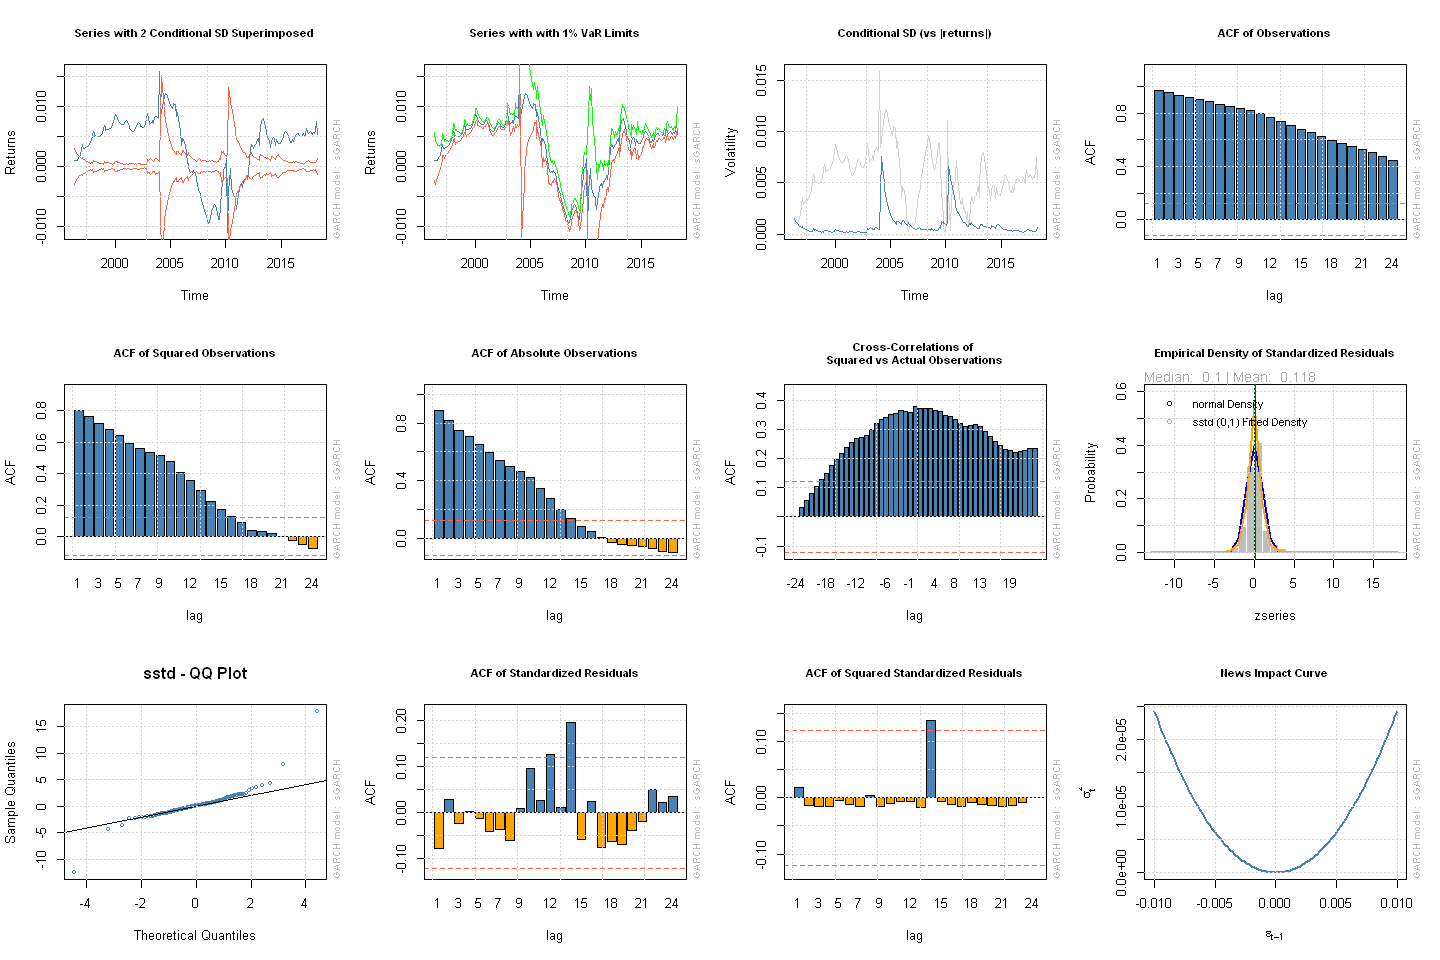

In [48]:
plot(fit, which='all')

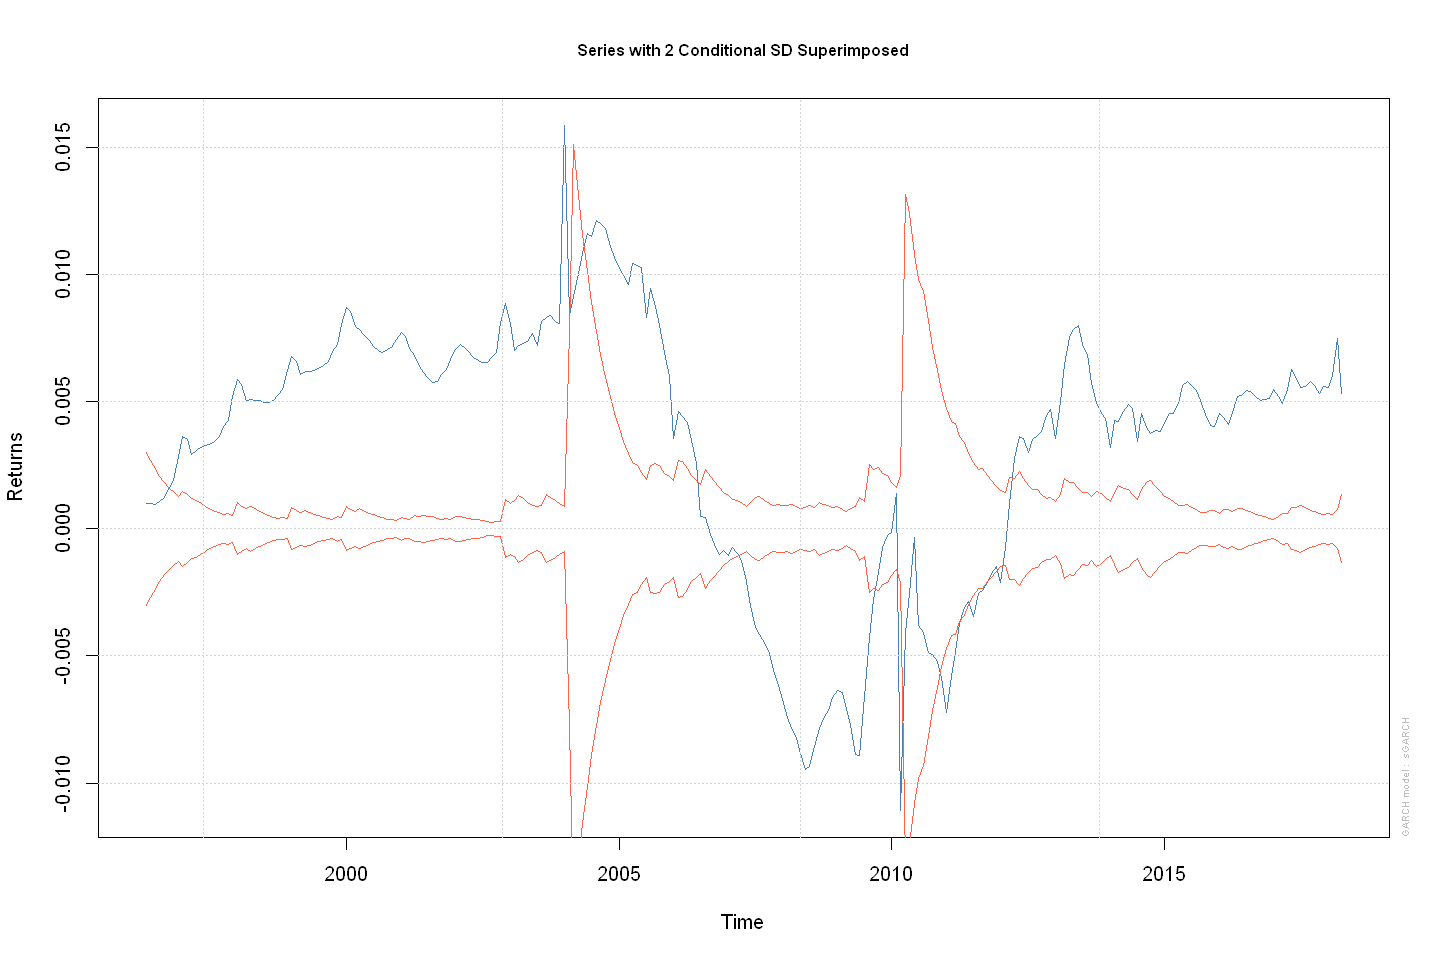

In [49]:
plot(fit, which=1)


please wait...calculating quantiles...


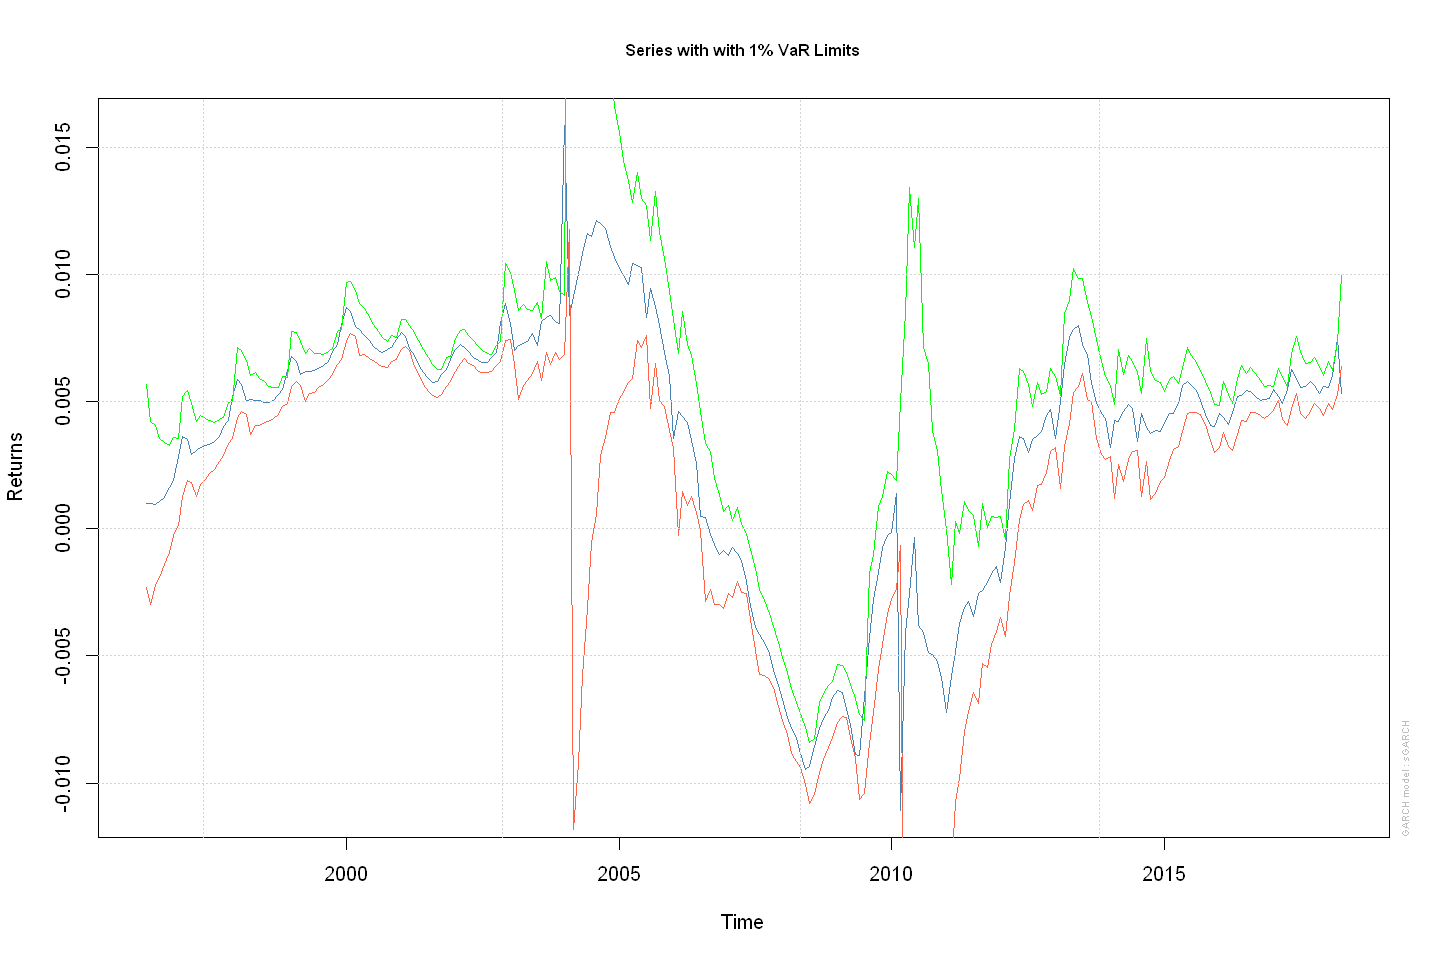

In [50]:
plot(fit, which=2)

In [51]:
persistence(fit)

[1] 0.999

In [353]:
library(parallel)

In [354]:
length(ts1)

[1] 264

In [397]:
fixedspec = getspec(fit)
setfixed(fixedspec) <- as.list(coef(fit))
forecast = ugarchforecast(fixedspec, 
                          n.ahead = 1, 
                          n.roll = 263, 
                          data = ts1,
                          out.sample = 263);
forecast@forecast$seriesFor

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
T+1,0.000829239,0.0009274792,0.0008773044,0.001041448,0.001223544,0.001712446,0.001875733,0.003331747,0.003666219,0.003394215,...,0.005423403,0.005581654,0.005833083,0.005568195,0.005246598,0.00575482,0.005451363,0.006321996,0.008195184,0.005400552


In [448]:
sigs <- forecast@forecast$sigmaFor

In [398]:
# We can see that this also produces the same information
fitted(forecast)

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
T+1,0.000829239,0.0009274792,0.0008773044,0.001041448,0.001223544,0.001712446,0.001875733,0.003331747,0.003666219,0.003394215,...,0.005423403,0.005581654,0.005833083,0.005568195,0.005246598,0.00575482,0.005451363,0.006321996,0.008195184,0.005400552


In [399]:
# Transposing the forecasts we can get
fores <- t(fitted(forecast))
head(fores)

,T+1
1996-05-01,0.0008292390
1996-06-01,0.0009274792
1996-07-01,0.0008773044
1996-08-01,0.0010414482
1996-09-01,0.0012235435
1996-10-01,0.0017124462


In [401]:
tail(fores)

,T+1
2017-11-01,0.005246598
2017-12-01,0.005754820
2018-01-01,0.005451363
2018-02-01,0.006321996
2018-03-01,0.008195184
2018-04-01,0.005400552


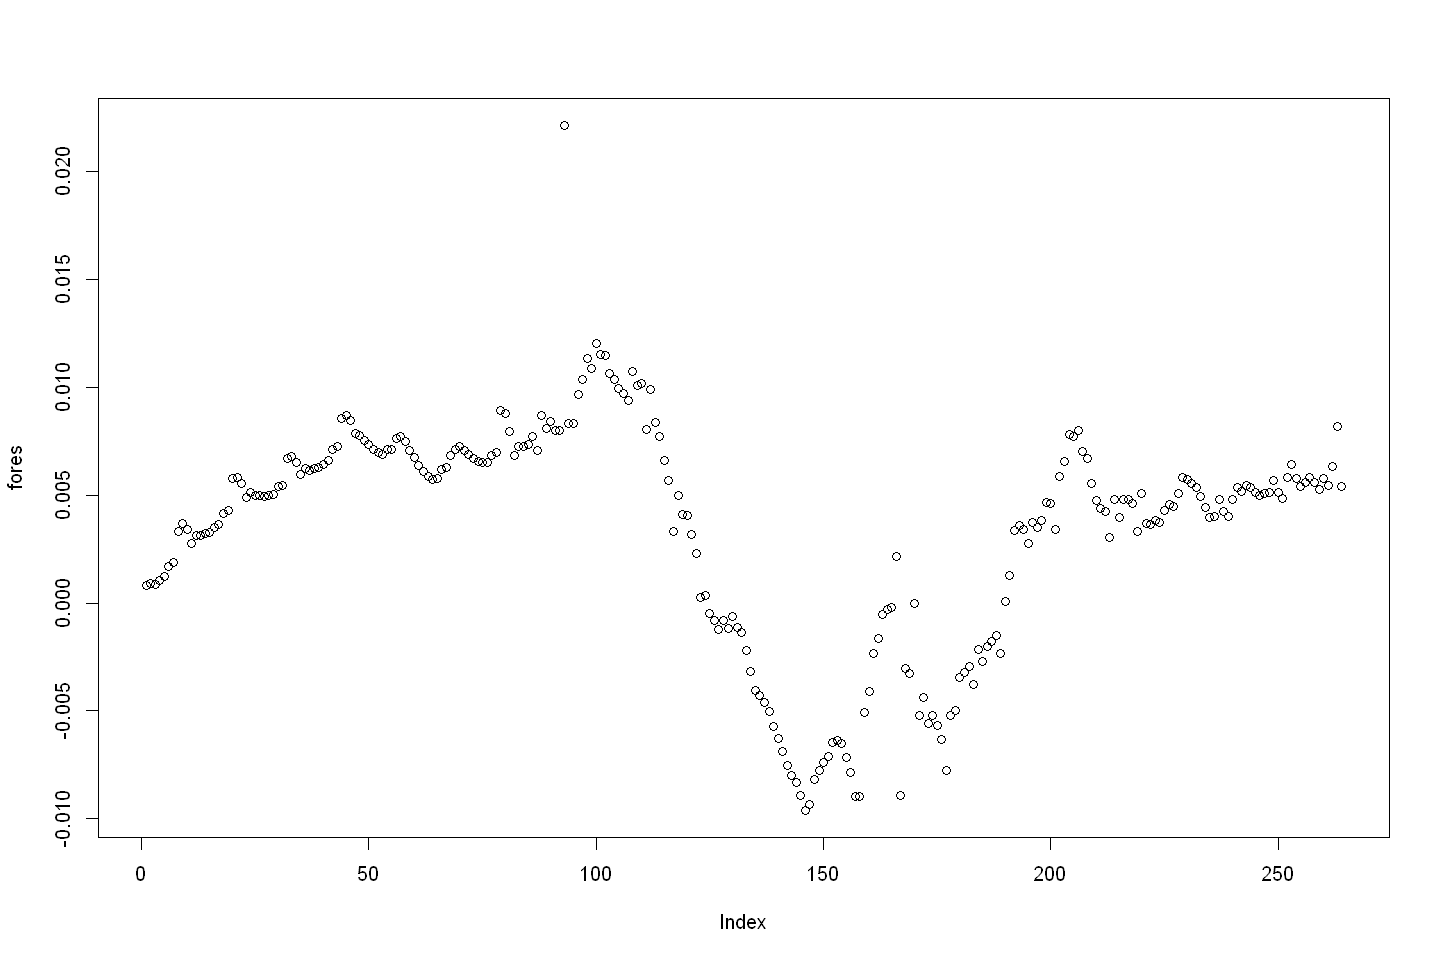

In [451]:
plot(fores)

In [452]:
# Now we need to shift the dates down one, because right now the table shows the next day's
# forecast on the date it was forecasted, indicated by the column being called T+1
# This will involve moving the dates forward by one, and dropping the last prediction
# We can get everything up to the second to last entry as such
tail(fores[-nrow(fores)])

[1] 0.005568195 0.005246598 0.005754820 0.005451363 0.006321996 0.008195184

In [ ]:
# First we will shift it to a time series

In [417]:
fts <- xts(fores, means[-1]$date)

In [418]:
tail(fts[-nrow(fts)])

                   T+1
2017-10-01 0.005568195
2017-11-01 0.005246598
2017-12-01 0.005754820
2018-01-01 0.005451363
2018-02-01 0.006321996
2018-03-01 0.008195184

In [453]:
# In the next few cells we can see that dropping the first row can be done with recursive [-1]
# indexing
head(means)

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-04-01,118299.1,NA
1996-05-01,118419.0,0.0010131971
1996-06-01,118537.4,0.0009991636
1996-07-01,118653.1,0.0009751320
1996-08-01,118780.3,0.0010713327
1996-09-01,118927.5,0.0012391198


In [431]:
head(means[-1])

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-05-01,118419.0,0.0010131971
1996-06-01,118537.4,0.0009991636
1996-07-01,118653.1,0.0009751320
1996-08-01,118780.3,0.0010713327
1996-09-01,118927.5,0.0012391198
1996-10-01,119120.5,0.0016214530


In [432]:
# This will be the notation to use to get the dates we want
head(means[-1][-1])

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-06-01,118537.4,0.0009991636
1996-07-01,118653.1,0.0009751320
1996-08-01,118780.3,0.0010713327
1996-09-01,118927.5,0.0012391198
1996-10-01,119120.5,0.0016214530
1996-11-01,119345.4,0.0018856534


In [454]:
# Making the appropriate time series forecast list
fts2 <- xts(fores[-nrow(fores)], means[-1][-1]$date)

In [455]:
head(fts2)

                   [,1]
1996-06-01 0.0008292390
1996-07-01 0.0009274792
1996-08-01 0.0008773044
1996-09-01 0.0010414482
1996-10-01 0.0012235435
1996-11-01 0.0017124462

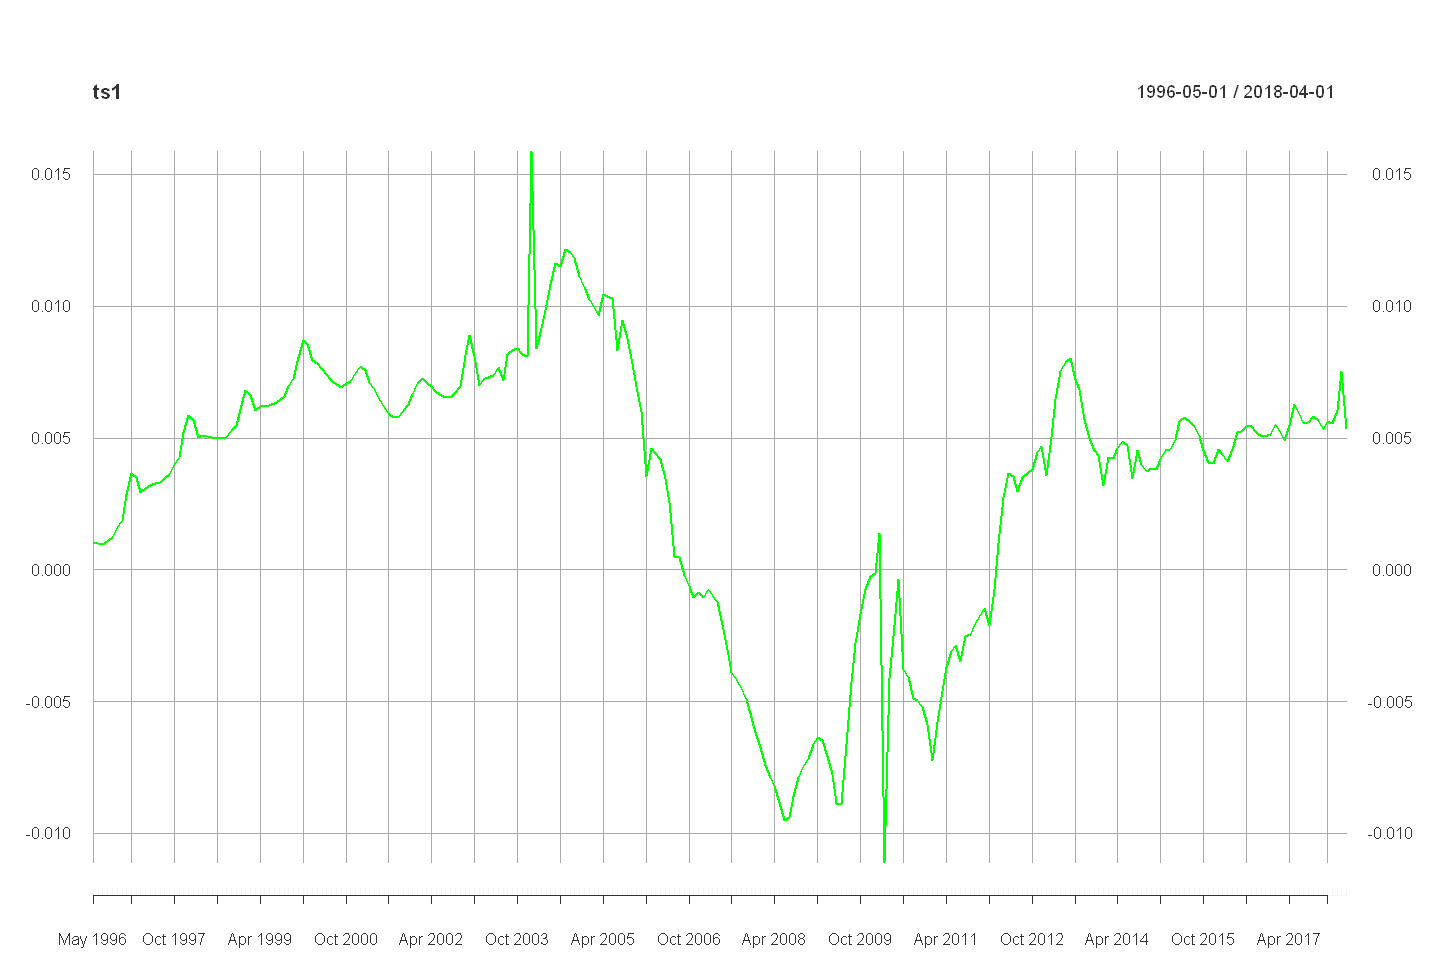

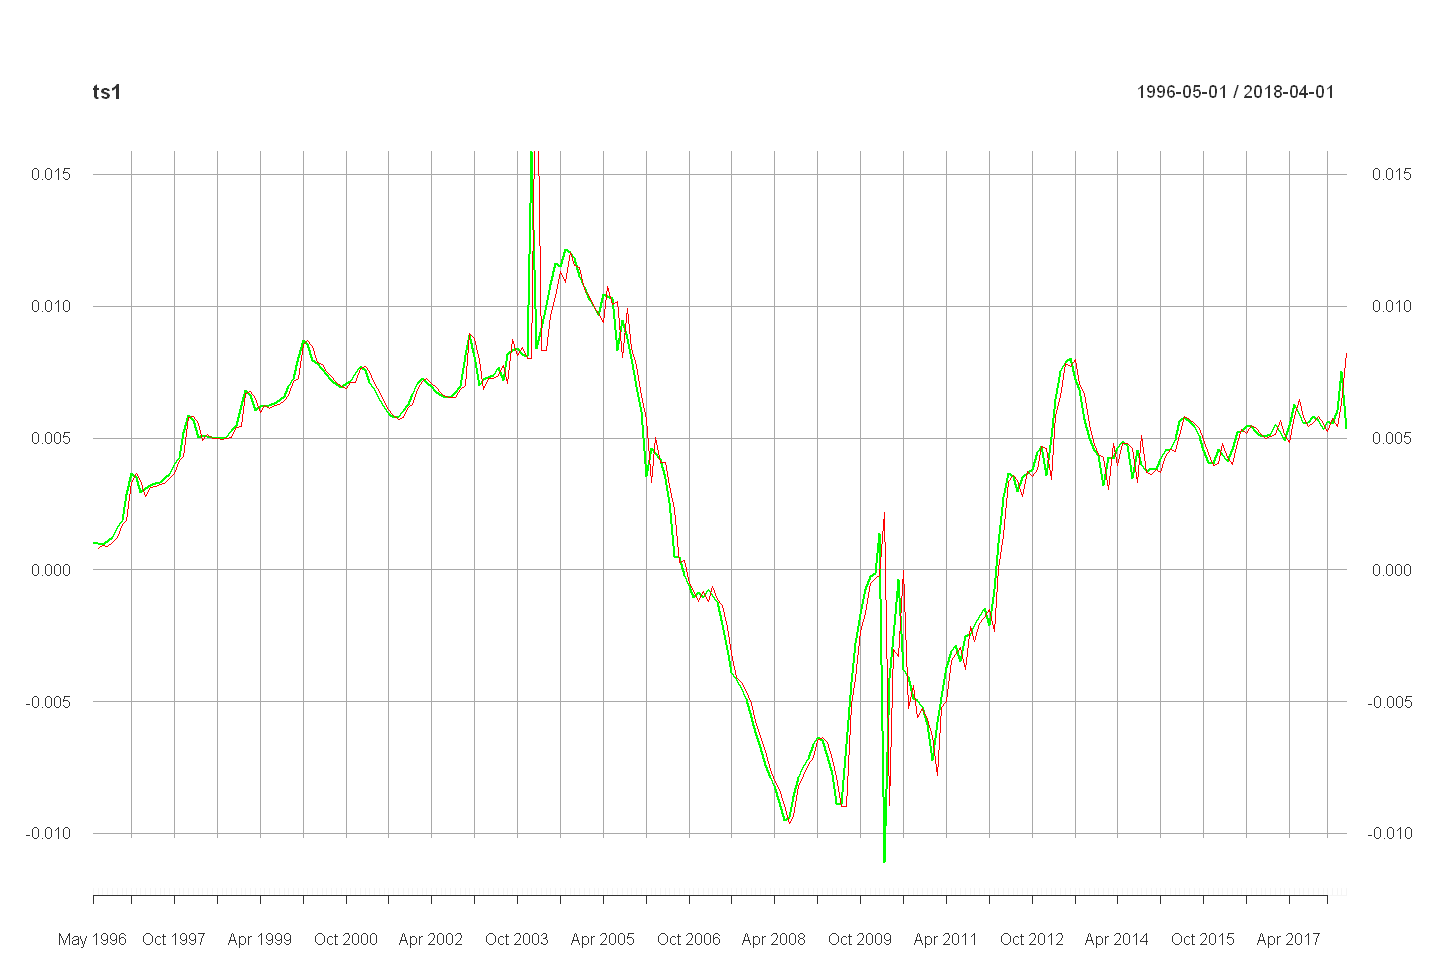

In [430]:
# We can see that the red (predictons) are close to the actual, but trailing behind the actual
# most of the time
plot(ts1, type='l', col='green')
lines(fts2, col='red')

In [433]:
args(ugarchroll)

function (spec, data, n.ahead = 1, forecast.length = 500, n.start = NULL, 
    refit.every = 25, refit.window = c("recursive", "moving"), 
    window.size = NULL, solver = "hybrid", fit.control = list(), 
    solver.control = list(), calculate.VaR = TRUE, VaR.alpha = c(0.01, 
        0.05), cluster = NULL, keep.coef = TRUE, ...) 
NULL

In [ ]:
# The next cells show an easier way to show the model performance on the actual data, also
# with refitting the model as new data becomes available, with no look-ahead bias

In [439]:
#cl = makePSOCKcluster(10)
roll = ugarchroll(spec, 
                  ts1, 
                  n.start = 200, 
                  refit.every = 1,
                  refit.window = "expanding", 
                  solver = "hybrid", 
                  calculate.VaR = TRUE,
                  VaR.alpha = c(0.01, 0.05), 
                  #cluster = cl, 
                  keep.coef = TRUE)
show(roll)
#stopCluster(cl)


*-------------------------------------*
*              GARCH Roll             *
*-------------------------------------*
No.Refits		: 64
Refit Horizon	: 1
No.Forecasts	: 64
GARCH Model		: sGARCH(1,1)
Distribution	: sstd 

Forecast Density:
               Mu Sigma   Skew  Shape Shape(GIG) Realized
2013-01-01 0.0046 5e-04 0.9629 3.1978          0   0.0036
2013-02-01 0.0034 7e-04 0.9558 3.2025          0   0.0050
2013-03-01 0.0059 1e-03 0.9671 3.2663          0   0.0065
2013-04-01 0.0065 9e-04 0.9634 3.2500          0   0.0075
2013-05-01 0.0078 9e-04 0.9661 3.2918          0   0.0078
2013-06-01 0.0077 8e-04 0.9614 3.2311          0   0.0080

..........................
               Mu Sigma   Skew  Shape Shape(GIG) Realized
2017-11-01 0.0056 8e-04 1.0262 2.1877          0   0.0053
2017-12-01 0.0052 8e-04 1.0293 2.1914          0   0.0056
2018-01-01 0.0057 8e-04 1.0210 2.1988          0   0.0055
2018-02-01 0.0055 8e-04 1.0231 2.2025          0   0.0060
2018-03-01 0.0061 8e-04 1.0197 2.209

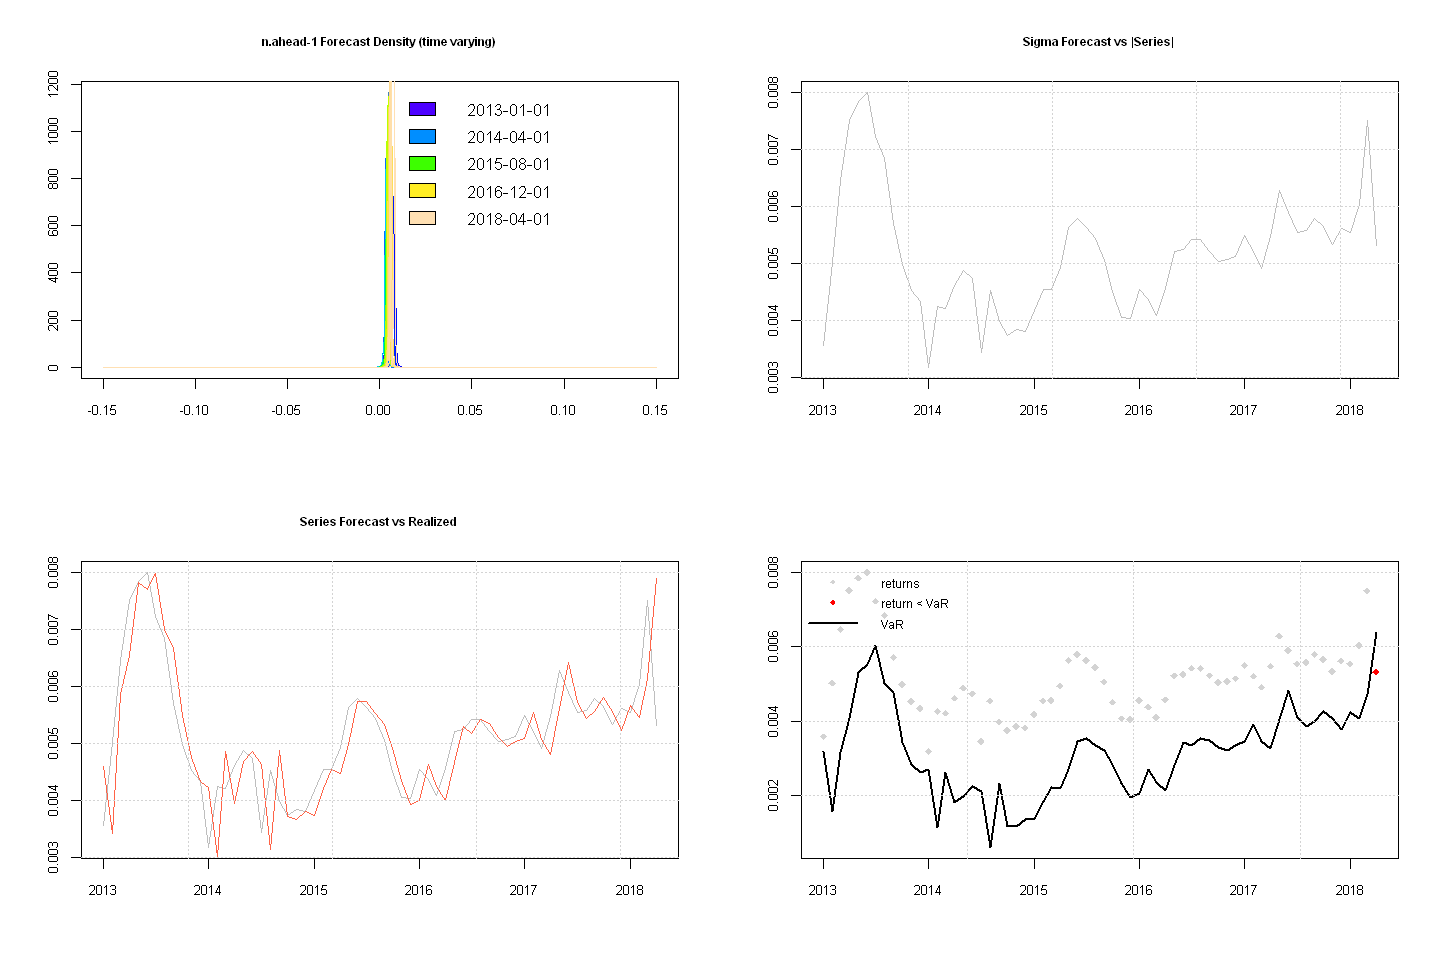

In [440]:
plot(roll, which='all')

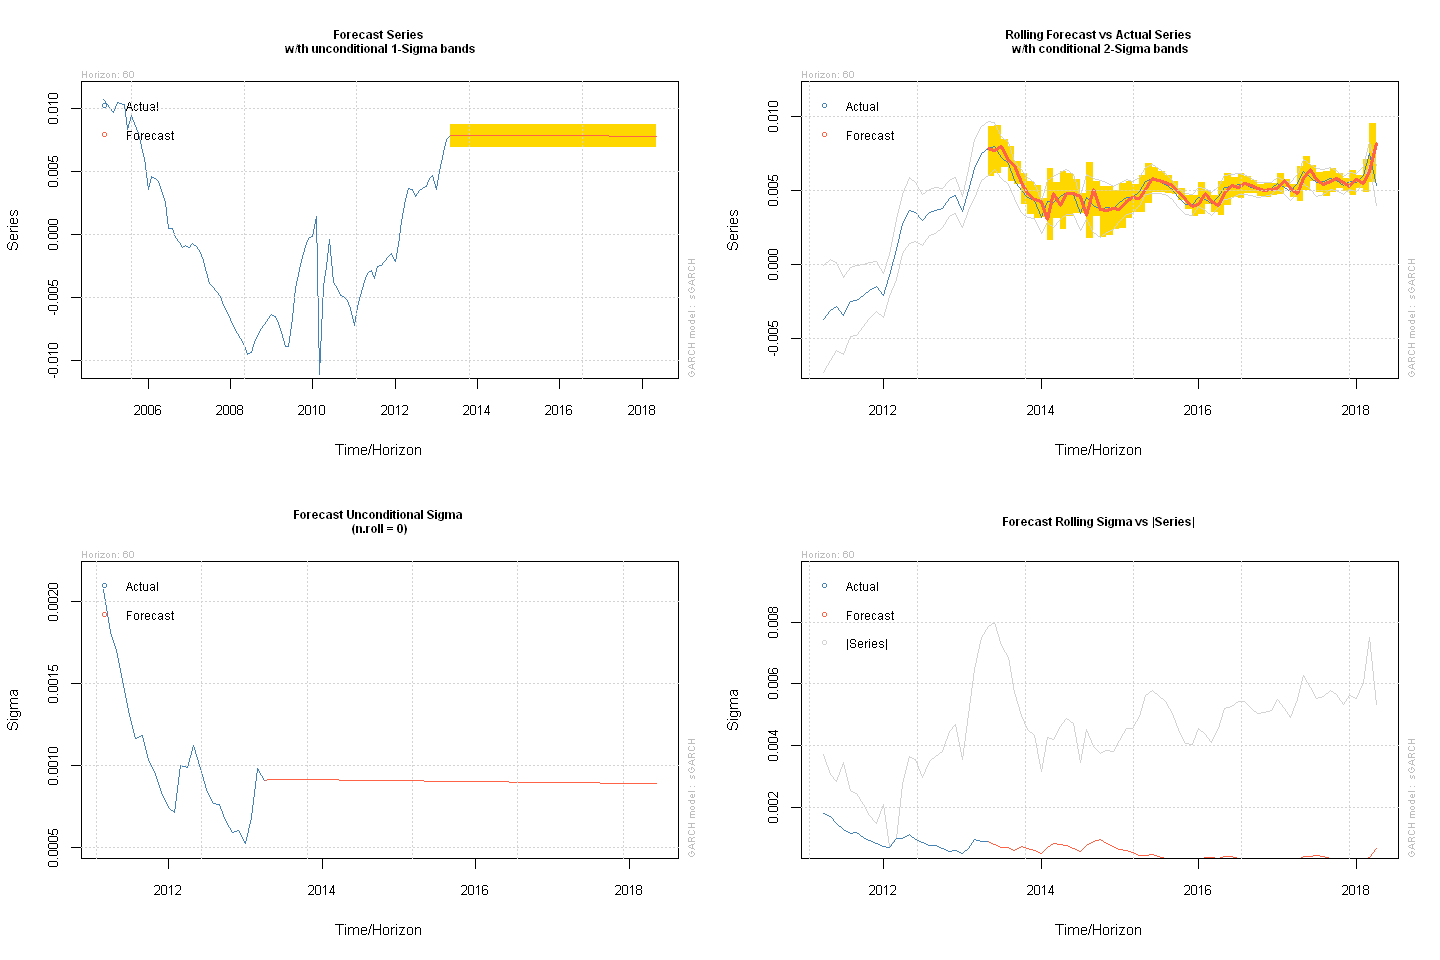

In [466]:
# Looking at yet another method of visualizing model performance, we can see that the rolling
# forecasts after each period, with a model refit each time, has been mostly successful at
# creating confidence bands around the last 60 months that contained the actual value, with the
# exception of the very last recorded month, where even an expanded band showing the influence
# of some conditional variance, the actual value fell beneath the confidence band.
ugfore <- ugarchforecast(fixedspec, ts1, n.ahead=60, n.roll=60, out.sample=60)
plot(ugfore, which='all')

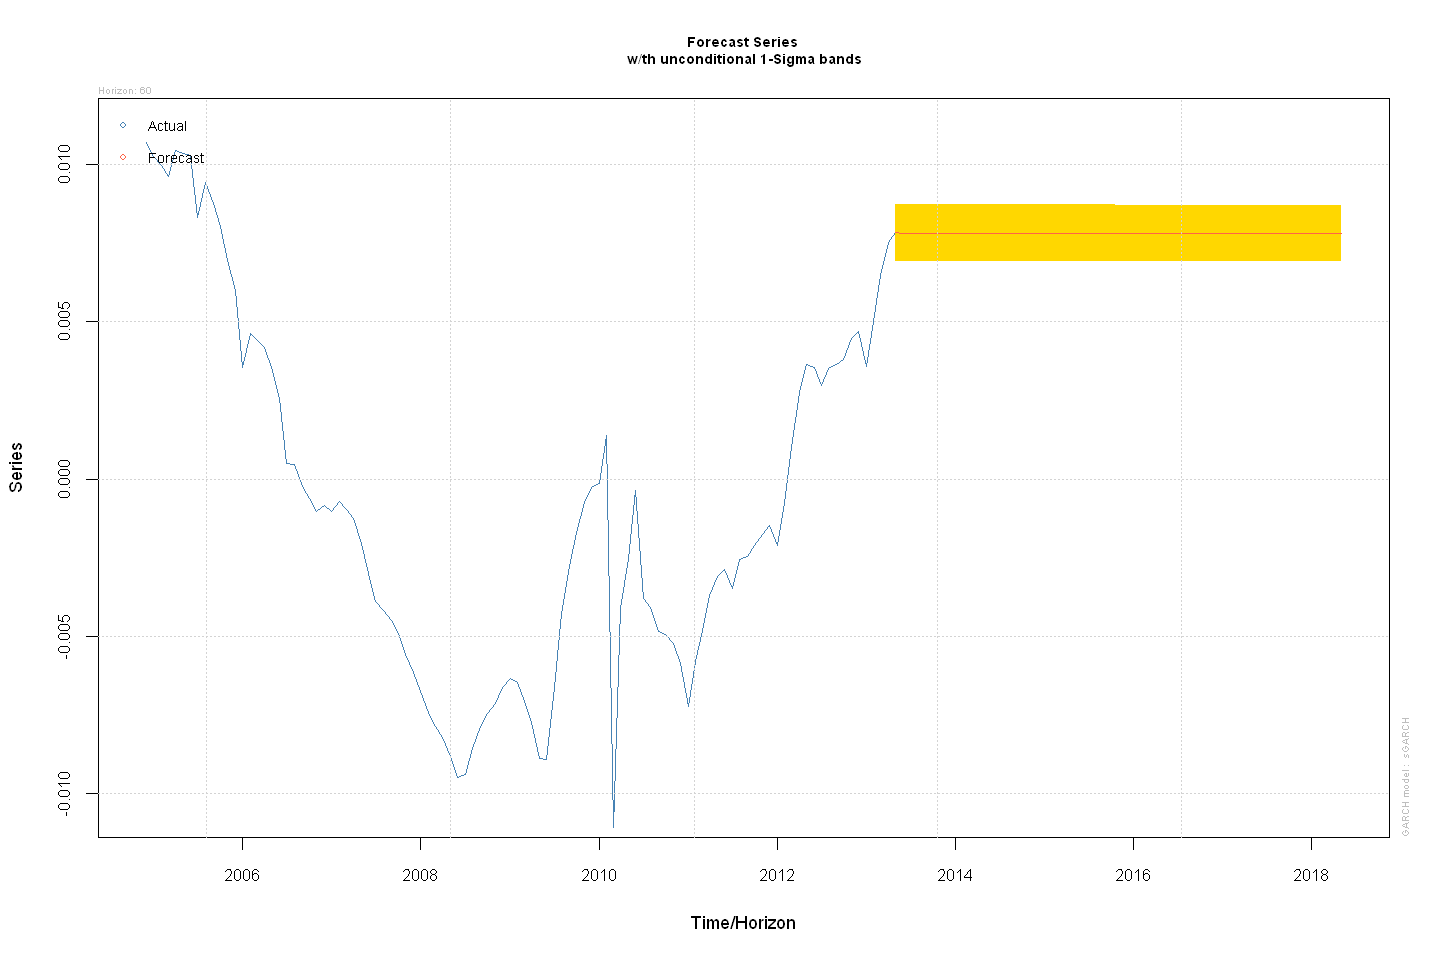

In [467]:
# We can see that unlike the forecast package, the ahead forecasts keep a constant variance,
# and do not reflect increasing uncertainty with time
plot(ugfore, which=1)

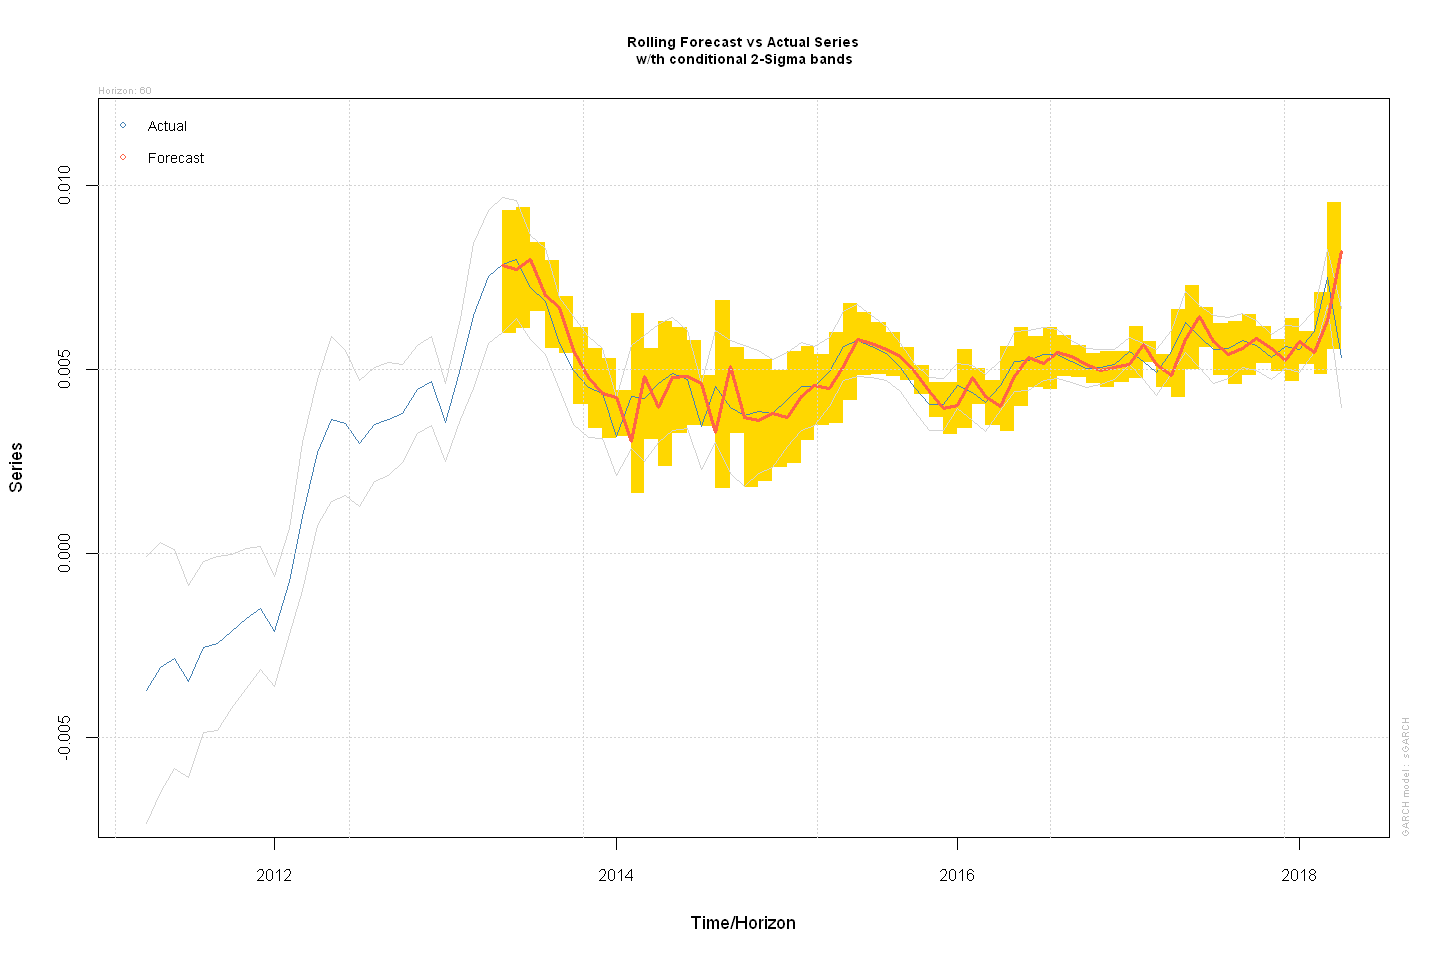

In [468]:
# Another look at the rolling forecast over the last 60 periods:
plot(ugfore, which=2)

In [ ]:
# We can see that the real strength in this model is not the n ahead forecasts, but the size of
# the confidence band around the next prediction, which increases when volatility is present.

In [483]:
ugfore <- ugarchforecast(fit, n.ahead=2)

In [484]:
ugfore


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 2
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=2018-04-01]:
      Series    Sigma
T+1 0.005401 0.001531
T+2 0.005400 0.001530



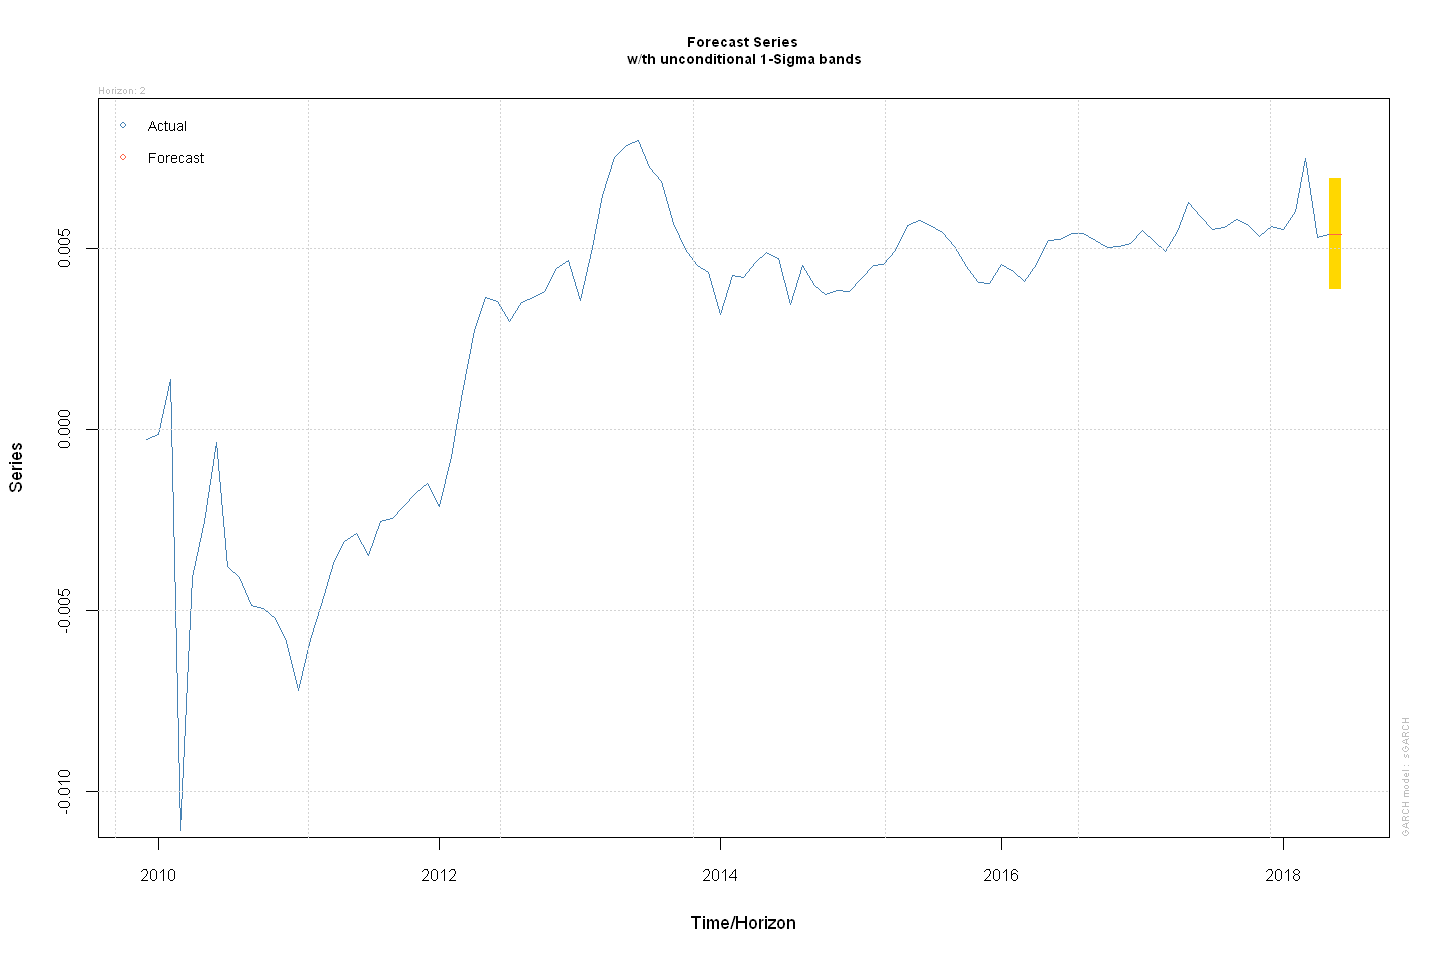

In [485]:
plot(ugfore, which=1)

In [501]:
ts3 <- copy(ts1)

In [502]:
head(ts3)

                   [,1]
1996-05-01 0.0010131971
1996-06-01 0.0009991636
1996-07-01 0.0009751320
1996-08-01 0.0010713327
1996-09-01 0.0012391198
1996-10-01 0.0016214530

In [505]:
lag(ts3, 1)

                    [,1]
1996-05-01            NA
1996-06-01  0.0010131971
1996-07-01  0.0009991636
1996-08-01  0.0009751320
1996-09-01  0.0010713327
1996-10-01  0.0012391198
1996-11-01  0.0016214530
1996-12-01  0.0018856534
1997-01-01  0.0028425900
1997-02-01  0.0036377804
1997-03-01  0.0035150544
1997-04-01  0.0029189971
1997-05-01  0.0030685798
1997-06-01  0.0031921350
1997-07-01  0.0032596971
1997-08-01  0.0032983070
1997-09-01  0.0034531241
1997-10-01  0.0036349513
1997-11-01  0.0040113532
1997-12-01  0.0042762482
1998-01-01  0.0052043207
1998-02-01  0.0058552499
1998-03-01  0.0056633285
1998-04-01  0.0050129185
1998-05-01  0.0051024305
1998-06-01  0.0050652031
1998-07-01  0.0050322018
1998-08-01  0.0049759053
1998-09-01  0.0049858588
1998-10-01  0.0050369869
1998-11-01  0.0052955905
1998-12-01  0.0054624550
1999-01-01  0.0062145164
1999-02-01  0.0067990795
1999-03-01  0.0065931686
1999-04-01  0.0060599632
1999-05-01  0.0061807866
1999-06-01  0.0061874970
1999-07-01  0.0062311750
